### This notebook serves to better organize the work from Backtesting.ipynb

In [1]:
import pandas as pd
import numpy as np
from collections import deque
import json
import requests
import matplotlib.pyplot as plt
from useful_functions import crypto_raw_to_pandas, parse_all_book_updates, parse_all_trade_prices, binary_price
from Vol import Vol
import matplotlib.pyplot as plt
from OrderBook import OrderBook
from DataTrackStrategy import DataTrackStrategy
from backtest import backtest_market

## IDEA -> ratio of crypto volatility to option volatility

In [36]:
# class Strategy:
#     def __init__(self):
#         pass

#     def on_warmup(self, timestamp, crypto_price, order_book):
#         """Called during warm-up period before official backtest start."""
#         raise NotImplementedError
#         pass

#     def on_update(self, timestamp, crypto_price, order_book):
#         """Main decision point — return actions or orders."""
#         raise NotImplementedError
#         pass

#     def on_trade(self, trade):
#         """Optional: Handle trade events if they matter."""
#         pass

#     def get_state(self) -> dict:
#         """Return current strategy metrics for logging."""
#         raise NotImplementedError

In [37]:
# def backtest_market(crypto_data_filepath, crypto_data_filename, crypto_symbol, 
#                     market_data_filepath, market_slug,
#                     unix_start_time, unix_end_time, 
#                     warm_up_duration, # how long to warm the models up before the start time
#                     strategy:Strategy, # the strategy that is used 
#                     time_precision: int = 13 # default milliseconds unix precision -> convert all timestamps to this
#                     ):
        
#         # TODO -> do we need to sort trades and book updates just in case?
#         # TODO -> Need to iterate through the timestamps of all of the market events to change the precision to the expected precision
#         # TODO -> need to add reacting to trades 

#         if time_precision < 10:
#             raise ValueError("time precision can't be less than 10 (secondly)")

#         # ensure all times have same precision
#         def adjust_precision(timestamp:int, precision:int) -> int:
#             return int(np.ceil(timestamp * 10**(precision - len(str(timestamp)))))
        
#         unix_start_time = adjust_precision(unix_start_time, time_precision)
#         unix_end_time = adjust_precision(unix_end_time, time_precision)
#         # warm_up_duration = adjust_precision(warm_up_duration, time_precision) -> can't because it's a time difference
        
#         # read in crypto data
#         all_coin_df = crypto_raw_to_pandas(f"{crypto_data_filepath}{crypto_data_filename}")
#         coin_df = all_coin_df[all_coin_df['symbol'] == crypto_symbol].sort_values(by="unix_timestamp").reset_index(drop=True)

#         # get token IDs of the market
#         url = "https://gamma-api.polymarket.com/events"
#         response = requests.get(url, params={"slug": market_slug})
#         yes_token_id, no_token_id = json.loads(response.json()[0]['markets'][0]['clobTokenIds'])

#         # get order book updates from our historical data
#         messages = []
#         with open (f"{market_data_filepath}{market_slug}.jsonl") as f:
#             for line in f:
#                 line_data = json.loads(line)
#                 messages.append(line_data)

#         order_book_updates = parse_all_book_updates(messages)
#         yes_book_updates = [update for update in order_book_updates if update['asset_id'] == yes_token_id]
#         no_book_updates = [update for update in order_book_updates if update['asset_id'] == no_token_id]
        
#         # get trades from both yes and no book perspectives
#         trades_yes_perspective, trades_no_perspective = parse_all_trade_prices(messages, yes_token_id, no_token_id)
        
#         # create queues for time arrival
#         crypto_price_queue = deque(zip(coin_df['unix_timestamp'], coin_df['value']))
#         market_update_queue = deque(yes_book_updates)
#         # trade_queue = deque(trades_yes_perspective)  # TODO -> add trade data?

#         warm_up_start_time = unix_start_time - warm_up_duration

#         warm_up_data = []
#         backtest_data = []

#         # flush any data that is before the warm up start window
#         latest_crypto_price = np.nan
#         while crypto_price_queue and crypto_price_queue[0][0] < warm_up_start_time:
#             _, latest_crypto_price = crypto_price_queue.popleft()
#         while market_update_queue and market_update_queue[0]['timestamp'] < warm_up_start_time:
#             market_update_queue.popleft()

#         # warm up strategy
#         while crypto_price_queue or market_update_queue:
#             # pick whichever event occurs next
#             next_times = []
#             if crypto_price_queue:
#                 next_crypto_time, _ = crypto_price_queue[0]
#                 next_times.append(next_crypto_time)
            
#             if market_update_queue:
#                 next_market_time = market_update_queue[0]['timestamp']
#                 next_times.append(next_market_time)
            
#             next_timestamp = min(next_times)

#             if next_timestamp >= unix_start_time:
#                 # exit once we hit backtest time
#                 break
                
#             # update crypto price if needed
#             if crypto_price_queue and crypto_price_queue[0][0] == next_timestamp:
#                 _, latest_crypto_price = crypto_price_queue.popleft()
            
#             # update order book if needed
#             market_updates = []
#             while market_update_queue[0]['timestamp'] == next_timestamp:
#                 market_update = market_update_queue.popleft()
#                 market_updates.append(market_update)

#             strategy.on_warmup(next_timestamp, latest_crypto_price, market_updates)
#             warm_up_data.append({
#                     "timestamp": next_timestamp,
#                     **strategy.get_state()
#                 }
#             )
            
#         # run the backtest
#         while crypto_price_queue or market_update_queue:
            
#             # pick whichever event occurs next
#             next_times = []
#             if crypto_price_queue:
#                 next_crypto_time, _ = crypto_price_queue[0]
#                 next_times.append(next_crypto_time)
            
#             if market_update_queue:
#                 next_market_time = market_update_queue[0]['timestamp']
#                 next_times.append(next_market_time)
            
#             next_timestamp = min(next_times)

#             if next_timestamp > unix_end_time:
#                 # exit once we hit end of backtest
#                 break
                
#             # update crypto price if needed
#             if crypto_price_queue and crypto_price_queue[0][0] == next_timestamp:
#                 _, latest_crypto_price = crypto_price_queue.popleft()
            
#             # update order book if needed
#             market_updates = []
#             while market_update_queue[0]['timestamp'] == next_timestamp:
#                 market_update = market_update_queue.popleft()
#                 market_updates.append(market_update)

#             strategy.on_update(next_timestamp, latest_crypto_price, market_updates)
#             backtest_data.append({
#                     "timestamp": next_timestamp,
#                     **strategy.get_state()
#                 }
#             )    
        
#         return warm_up_data, backtest_data

In [38]:
# class DataTrackStrategy(Strategy):
#     def __init__(self, market_strike_set_time, market_resolve_time, time_precision, effective_memory=300):
#         self.crypto_price = np.nan

#         self.market_strike_set_time = market_strike_set_time
#         self.market_resolve_set_time = market_resolve_time

#         secs_in_year = 3.154e+7
#         self.annualize_factor = secs_in_year * 10**(time_precision - 10)

#         self.strike_price = np.nan
#         self.resolve_price = np.nan

#         self.theo_price = np.nan

#         self.vol_tracker = Vol(effective_memory=effective_memory) # 5 minutes of effective memory?
#         self.order_book = OrderBook()
        
#     def on_warmup(self, timestamp, crypto_price, book_updates):
#         """Called during warm-up period before official backtest start."""
#         #TODO -> this assumes if the crypto price is the same, then it wasn't an update for vol
#         if crypto_price != self.crypto_price:
#             self.vol_tracker.update_vol_from_price(self.crypto_price)
#             self.crypto_price = crypto_price

#         self.order_book.batch_update(book_updates)
        
#         if timestamp == self.market_strike_set_time:
#             self.strike_price = crypto_price
        
#         if timestamp == self.market_resolve_set_time:
#             self.resolve_price = crypto_price

#     def on_update(self, timestamp, crypto_price, book_updates):
#         """Main decision point — return actions or orders."""
        
#         if crypto_price != self.crypto_price:
#             self.vol_tracker.update_vol_from_price(self.crypto_price)
#             self.crypto_price = crypto_price

#         self.order_book.batch_update(book_updates)
        
#         T = (self.market_resolve_set_time - timestamp) / self.annualize_factor
#         self.theo_price = binary_price(self.crypto_price, self.strike_price,
#                                     T, self.vol_tracker.vol, r=4.2
#                         )
        
#         if timestamp == self.market_strike_set_time:
#             self.strike_price = crypto_price
        
#         if timestamp == self.market_resolve_set_time:
#             self.resolve_price = crypto_price

#     def on_trade(self, trade):
#         """Optional: Handle trade events if they matter."""
#         pass

#     def get_state(self):
#         """Return current strategy metrics for logging."""
#         return{
#             "crypto_price": self.crypto_price,
#             "vol": self.vol_tracker.vol,
#             "market_spread": self.order_book.spread,
#             "best_bid": self.order_book.best_bid,
#             "best_ask": self.order_book.best_ask,
#             "theo_price": self.theo_price,
#             "mid_price": self.order_book.mid,
#             "lwm_price": self.order_book.lwm
#         }

In [2]:
## backtest inputs
crypto_data_filepath = "Chainlink_prices/"
crypto_data_filename = "chainlink_crypto_prices_2025-11-04.jsonl"
market_data_filepath = "btc_contracts-2/"
crypto_symbol = "btc/usd"
market_slug ='btc-updown-15m-1762266600'
unix_start_time = 1_762_266_600_000
unix_end_time = unix_start_time + 900_000 # end time
warm_up_duration = 900_000*4 # 15 minutes in milliseconds?
time_precision = 13 # in millisecond format (10 = second format)
strategy = DataTrackStrategy(unix_start_time, unix_end_time, time_precision=13, effective_memory=300*10)

warm_up_data, backtest_data = backtest_market(crypto_data_filepath, crypto_data_filename, crypto_symbol,
                                market_data_filepath, market_slug,
                                unix_start_time, unix_end_time,
                                warm_up_duration,
                                strategy,
                                time_precision=13 
                            )

[CROSS WARNING] Book crossed at 1762266681839: bid=0.45, ask=0.44
[CROSS WARNING] Book crossed at 1762267148190: bid=0.01, ask=0.01
[CROSS WARNING] Book crossed at 1762267281096: bid=0.09, ask=0.09
[CROSS WARNING] Book crossed at 1762267312816: bid=0.06, ask=0.05
[CROSS WARNING] Book crossed at 1762267393467: bid=0.74, ask=0.71


In [ ]:
backtest_data[-1]

{'timestamp': 1761786900000,
 'crypto_price': 110512.0406820323,
 'strike_price': 110561.0117390768,
 'vol': np.float64(0.2313543620394864),
 'market_spread': 0.049999999999999996,
 'best_bid': 0.01,
 'best_ask': 0.06,
 'theo_price': 0,
 'mid_price': 0.034999999999999996,
 'lwm_price': 0.059431316402173036,
 'bid_data': SortedDict(<function OrderBook.__init__.<locals>.<lambda> at 0x12ccfd300>, {0.01: 369.42}),
 'ask_data': SortedDict({0.06: 4.25, 0.07: 11.0, 0.08: 73.99, 0.09: 5.0, 0.13: 5.0, 0.38: 20.0, 0.39: 20.0, 0.4: 20.0, 0.41: 20.0, 0.42: 20.0, 0.43: 20.0, 0.45: 20.0, 0.46: 20.0, 0.47: 20.0, 0.48: 20.0, 0.53: 20.0, 0.54: 20.0, 0.58: 20.0, 0.59: 20.0, 0.6: 20.0, 0.62: 20.0, 0.63: 20.0, 0.64: 20.0, 0.66: 20.0, 0.9: 10.0, 0.91: 10.0, 0.92: 10.0, 0.93: 20.0, 0.94: 20.0, 0.95: 30.0, 0.96: 75.0, 0.97: 198.0, 0.98: 219.0, 0.99: 432.0})}

In [ ]:
backtest_df = pd.DataFrame(backtest_data)
# backtest_df.dropna() # once we have market data, then we can begin tracking everything 

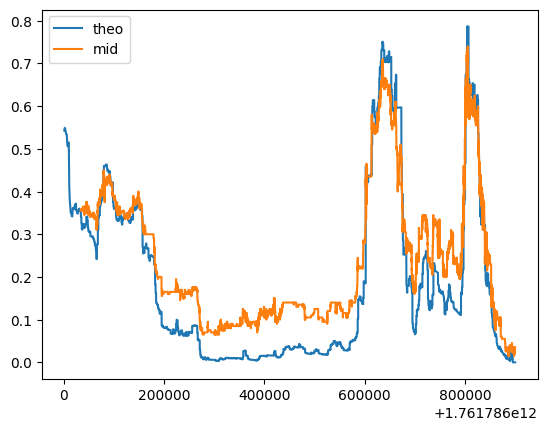

In [ ]:
backtest_df = backtest_df[(backtest_df['timestamp']>=unix_start_time) & (backtest_df['timestamp']<=unix_end_time)]
plt.plot(backtest_df['timestamp'], backtest_df['theo_price'], label="theo")
plt.plot(backtest_df['timestamp'], backtest_df['mid_price'], label="mid")
# plt.plot(backtest_df['timestamp'], backtest_df['lwm_price'], label="lwm")
# plt.plot(backtest_df['timestamp'], backtest_df['market_spread'], label="spread")
plt.legend()

In [ ]:
# IMPLIED VOL IS WEIRD WITH BINARY (there are 2 roots)
# S = 100
# X = 95
# T = 0.5
# vol = 0.2
# r = 0.04
from useful_functions import implied_vol_binary, binary_price
# import numpy as np
# from scipy.optimize import brentq
# comp_price = binary_price(S, X, T, vol, r)

# from scipy.optimize import newton

# def implied_vol_binary_newton(S, X, T, r, price, vol0=0.2):
#     f = lambda vol: binary_price(S, X, T, vol, r) - price
#     return newton(f, vol0, maxiter=100, tol=1e-8)

# comp_vol = implied_vol_binary_newton(S, X, T, r, comp_price, vol0 = 0.6)
# print(comp_price)
# print("VOLs", vol, comp_vol)



In [41]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

S, X, T, r = 100, 95, 0.5, 0.0

def binary_price(S,X,T,vol,r):
    d2 = (np.log(S/X) + (r - 0.5*vol**2)*T)/(vol*np.sqrt(T))
    return np.exp(-r*T)*norm.cdf(d2)

# vols = np.linspace(0.001, 10, 500)
# prices = [binary_price(S,X,T,v,r) for v in vols]

# plt.plot(vols, prices)
# plt.xlabel("Volatility")
# plt.ylabel("Binary Call Price")
# plt.show()

In [78]:
def implied_vol_binary(S, X, T, r, price, anchor_vol, dist_weight = 10):
    """
        Solve for implied volatility(s) sigma from a binary (cash-or-nothing) call price
        p = exp(-rT) * N(d2) under Black-Scholes.
        Returns:
        IF WE HAVE AN ANCHOR:
            - a single sigma if `anchor_vol` is provided (the root closest to anchor_vol)
                - and a confidence label based on distance from anchor (0 to 1 for high and 0 to -1 for low)
            - np.nan if no valid root + confidence = 0.0
        
            - if you want the other level, you can back it out
        
    """
    p_min = 0.0
    p_max = np.exp(-r * T)
    if not (p_min < price < p_max):
        return np.nan, 0.0

    q = price / np.exp(-r * T)
    if not (0.0 < q < 1.0):
        return np.nan, 0.0
    
    z = norm.ppf(q) #inverse cdf of price / e^-rt

    a = 0.5*T
    b = z*np.sqrt(T)
    c = -(np.log(S/X) + r*T)

    disc = b**2 - 4 * a * c
    if disc < 0:
        return np.nan, 0.0

    sqrt_disc = np.sqrt(disc)
    vol_high = (-b + sqrt_disc) / (2 * a)
    vol_low = (-b - sqrt_disc) / (2 * a)

    # With anchor, figure out which root to use
    if vol_high < 0 and vol_low < 0:
        return np.nan, 0.0
    
    if vol_low < 0:
        return vol_high, 1.0
    
    if vol_high < 0:
        return vol_low, -1.0

    # if both roots could be valid and we have an anchor to work with
    dist_high = abs(vol_high - anchor_vol)
    dist_low = abs(vol_low - anchor_vol)
    
    print(dist_high, dist_low)
    def flipped_sigmoid(x, weight = 10):
        # weight = how heavily to penalize excess distance in confidence
        return 1 / (1 + np.exp(weight*x))
    
    sig_high = flipped_sigmoid(dist_high, weight=dist_weight)
    sig_low = flipped_sigmoid(dist_low, weight=dist_weight)
    
    confidence = (sig_high - sig_low)/ (sig_high + sig_low)

    if sig_high > sig_low:
        return vol_high, confidence
    else:
        return vol_low, confidence

In [87]:
price = 0.01
S = 80
X = 100
T = 0.1
r = 0.04

vol, root_confidence = implied_vol_binary(S, X, T, r, price, anchor_vol=0.5, dist_weight = 100) # 10 means 0.03 dist difference is like 0.16 confidence
vol, root_confidence

13.899239282617406 0.19561787673219988


/var/folders/1d/dkqlxg7d3yv8ccfw3vkrtnsm0000gn/T/ipykernel_67116/631815549.py:54: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(weight*x))


(np.float64(0.3043821232678001), np.float64(-1.0))

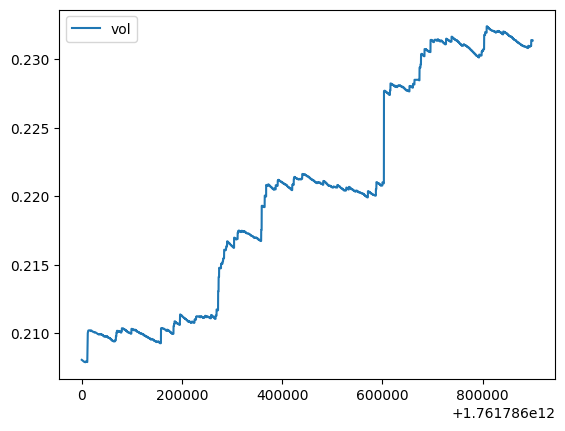

In [ ]:
# backtest_df = backtest_df[(backtest_df['timestamp']>=unix_start_time) & (backtest_df['timestamp']<=unix_end_time)]
plt.plot(backtest_df['timestamp'], backtest_df['vol'], label="vol") #176786601951
plt.legend()

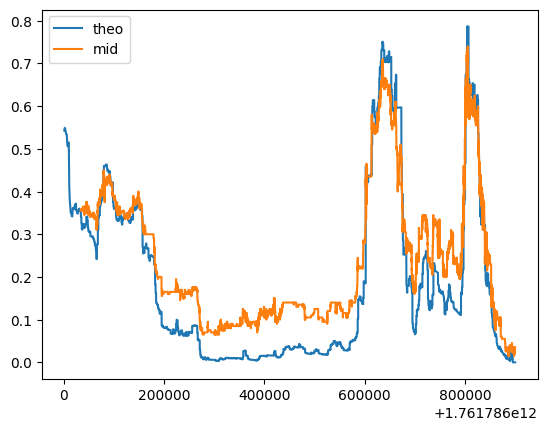

In [ ]:
backtest_df = backtest_df[(backtest_df['timestamp']>=unix_start_time) & (backtest_df['timestamp']<=unix_end_time)]
plt.plot(backtest_df['timestamp'], backtest_df['theo_price'], label="theo")
plt.plot(backtest_df['timestamp'], backtest_df['mid_price'], label="mid")
# plt.plot(backtest_df['timestamp'], backtest_df['lwm_price'], label="lwm")
# plt.plot(backtest_df['timestamp'], backtest_df['market_spread'], label="spread")
plt.legend()

In [3]:
import json
with open("orderbook_interactive_plot_test_data.json", "w") as f:
    json.dump(backtest_data, f, indent=4)

In [10]:
bid_prices, bid_sizes = [1], [1]
a, b= zip(bid_prices, bid_sizes)
a

ValueError: not enough values to unpack (expected 2, got 1)

### What I noticed: Chainlink severely underestimates the volatility of the markets, as it is naturally a smoothed metric from all of the different exchanges. We should compare results from many trials to see 

In [ ]:
# checking return distribution of chainlink prices

all_coin_df = crypto_raw_to_pandas(f"{crypto_data_filepath}{crypto_data_filename}")
coin_df = all_coin_df[all_coin_df['symbol'] == crypto_symbol].sort_values(by="unix_timestamp").reset_index(drop=True)

<Axes: >

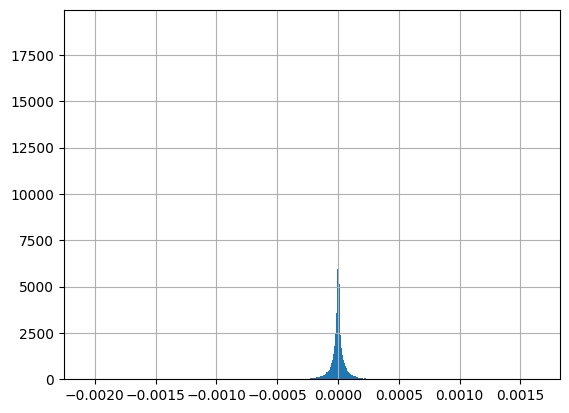

In [ ]:
returns: pd.Series = (np.log(coin_df['value']) - np.log(coin_df['value'].shift(1))).dropna()
returns.hist(bins=500)

pandas.core.series.Series

In [ ]:
returns.skew(), returns.kurt()

(np.float64(-0.34642446000312516), np.float64(46.56510530312552))

In [ ]:
from scipy.stats import t
